In [75]:
import pandas as pd
import numpy as np

# Import Regular Expression
import re

# Loading the data
df = pd.read_csv("Data/jumia_phones.csv")

# Display the first few rows of the data to get a sense of the data structure
df.head()

,Name,Price,Old Price,Discount,Rating,Number of Reviews,Search Ranking
0,"XIAOMI Redmi A3, 6.71"", 3GB RAM + 64GB (Dual S...","KSh 11,000",NaN,NaN,4.1 out of 5,4.1 out of 5(220),"Page 1, Rank 1"
1,"Tecno Spark 20, Android 13, 6.6"", 128GB + 4GB ...","KSh 12,925","KSh 15,000",14%,4.4 out of 5,4.4 out of 5(135),"Page 1, Rank 2"
2,"Itel S23 6.6"", 128GB + 4GB RAM, 50MP Camera, (...","KSh 10,000",NaN,NaN,4.2 out of 5,4.2 out of 5(151),"Page 1, Rank 3"
3,"Samsung Galaxy A05, 6.7'' 4GB RAM + 128GB ROM ...","KSh 14,000",NaN,NaN,4.5 out of 5,4.5 out of 5(29),"Page 1, Rank 4"
4,"Itel S23 6.6"", 128GB + 4GB RAM, 50MP Camera, (...","KSh 10,000",NaN,NaN,4.3 out of 5,4.3 out of 5(249),"Page 1, Rank 5"


In [76]:
data = df['Name']

#convert the data type of data to list 
data = data.tolist()

data[97]

'Itel S23 6.6", 128GB ROM + Up To 8GB RAM, 50MP Camera, 5000mAh+CELLINY 7'

In [77]:
# Column name to work with
product_column = 'Name'

# Function to extract a feature based on regex and rename the column
def extract_feature(df, column, pattern, feature_name):
    def extractor(name):
        match = re.search(pattern, name)
        return match.group(1).strip() if match else None

    return df[column].apply(extractor).rename(feature_name)

# Define regex patterns
patterns = {
    'Brand': r"(?P<brand>[\w\s]+)(?=\+|,\s|\s|$)",
    'Screen Size': r"(?P<screen_size>\d+(\.\d+)?)(?=['\"]{1,2})",
    'RAM': r"\b(?P<RAM>\d\s?GB)\b",
    'ROM': r"\b(?P<ROM>\d{2,}\s?GB)\b",
    'Color': r"[,-]\s*(?P<Color>([A-Z][a-z]+(?:\s[A-Z][a-z]+)*))\s*(?:\+.*)?(?=\s*\(|$)",
    'Warranty': r"(\d+)\s*(?:YR|WRTY)",
    'Camera': r'(\d+MP)',
    'Battery': r'(\d{4}mAh)',
    'Number of SIMs': r'\(?(Dual\s+Sim|DUAL\s+SIM|Single\s+Sim|Single)\)?'
}

# Extract features using the defined patterns
extracted_features = {
    name: extract_feature(df, product_column, pattern, name)
    for name, pattern in patterns.items()
}

# Special handling for Warranty and Number of SIMs
extracted_features['Warranty'] = extracted_features['Warranty'].apply(lambda x: 2 if x == '2' else (1 if x == '1' else 0))
extracted_features['sim_cards'] = extracted_features['Number of SIMs'].apply(lambda x: 2 if x and 'Dual' in x else 1)

# Clean up the Brand column to title case
extracted_features['Brand'] = extracted_features['Brand'].str.lower().str.title()

# Combine all extracted features into a single DataFrame
extracted_features_df = pd.DataFrame(extracted_features)

# Concatenate with the original DataFrame, excluding the product column
final_df = pd.concat([extracted_features_df, df.drop(columns=[product_column])], axis=1)

# Display the final DataFrame
final_df.head()

,Brand,Screen Size,RAM,ROM,Color,Warranty,Camera,Battery,Number of SIMs,sim_cards,Price,Old Price,Discount,Rating,Number of Reviews,Search Ranking
0,Xiaomi Redmi A3,6.71,3GB,64GB,Midnight Black,2,None,5000mAh,None,1,"KSh 11,000",NaN,NaN,4.1 out of 5,4.1 out of 5(220),"Page 1, Rank 1"
1,Tecno Spark 20,6.6,4GB,128GB,Gravity Black,1,50MP,5000mAh,None,1,"KSh 12,925","KSh 15,000",14%,4.4 out of 5,4.4 out of 5(135),"Page 1, Rank 2"
2,Itel S23,6.6,4GB,128GB,Mystery White,1,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,4.2 out of 5,4.2 out of 5(151),"Page 1, Rank 3"
3,Samsung Galaxy A05,6.7,4GB,128GB,Black,0,50MP,5000mAh,Dual Sim,2,"KSh 14,000",NaN,NaN,4.5 out of 5,4.5 out of 5(29),"Page 1, Rank 4"
4,Itel S23,6.6,4GB,128GB,Starry Black,0,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,4.3 out of 5,4.3 out of 5(249),"Page 1, Rank 5"


In [78]:
# Let us clean the Rating column to keep only the result and rename it to Ratings_out_of_5
final_df['Ratings_out_of_5'] = final_df['Rating'].str.extract(r'(\d+\.\d+)')[0]

# Drop the Rating column
final_df.drop(columns=['Rating'], inplace=True)

# Clean the Number of Reviews column to extract the number in parentheses
final_df['Number of Reviews'] = final_df['Number of Reviews'].str.extract(r'\((\d+)\)')[0]

# Define regex pattern to extract page and rank
pattern = r'Page (?P<Page>\d+), Rank (?P<Rank>\d+)'

# Extract page and rank into new columns
final_df[['Page', 'Rank']] = final_df['Search Ranking'].str.extract(pattern)

# Display the cleaned DataFrame
final_df.head()

,Brand,Screen Size,RAM,ROM,Color,Warranty,Camera,Battery,Number of SIMs,sim_cards,Price,Old Price,Discount,Number of Reviews,Search Ranking,Ratings_out_of_5,Page,Rank
0,Xiaomi Redmi A3,6.71,3GB,64GB,Midnight Black,2,None,5000mAh,None,1,"KSh 11,000",NaN,NaN,220,"Page 1, Rank 1",4.1,1,1
1,Tecno Spark 20,6.6,4GB,128GB,Gravity Black,1,50MP,5000mAh,None,1,"KSh 12,925","KSh 15,000",14%,135,"Page 1, Rank 2",4.4,1,2
2,Itel S23,6.6,4GB,128GB,Mystery White,1,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,151,"Page 1, Rank 3",4.2,1,3
3,Samsung Galaxy A05,6.7,4GB,128GB,Black,0,50MP,5000mAh,Dual Sim,2,"KSh 14,000",NaN,NaN,29,"Page 1, Rank 4",4.5,1,4
4,Itel S23,6.6,4GB,128GB,Starry Black,0,50MP,5000mAh,None,1,"KSh 10,000",NaN,NaN,249,"Page 1, Rank 5",4.3,1,5


In [79]:
# Rename Brand to phone_name, Screen Size to display, ROM to storage
final_df.rename(columns={'Brand': 'phone_name', 'Screen Size': 'display', 'ROM': 'storage'}, inplace=True)

# Drop the Search Ranking and Old Price column
final_df.drop(columns=['Search Ranking', 'Old Price', 'Number of SIMs'], inplace=True)

# Change all column names to lowercase and add _ between the parts of the column names
final_df.columns = final_df.columns.str.lower().str.replace(' ', '_')

# Display the cleaned DataFrame
final_df['color'].head(100)

# Get the 97th entry in the final_df
final_df.iloc[97]

phone_name            Itel S23
display                    6.6
ram                        8GB
storage                  128GB
color                     None
warranty                     0
camera                    50MP
battery                5000mAh
sim_cards                    1
price                KSh 9,999
discount                   50%
number_of_reviews           41
ratings_out_of_5           4.5
page                         3
rank                        18
Name: 97, dtype: object

In [80]:
# Let us check our modified DataFrame
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   phone_name         12000 non-null  object
 1   display            11100 non-null  object
 2   ram                12000 non-null  object
 3   storage            12000 non-null  object
 4   color              9600 non-null   object
 5   warranty           12000 non-null  int64 
 6   camera             8700 non-null   object
 7   battery            9300 non-null   object
 8   sim_cards          12000 non-null  int64 
 9   price              12000 non-null  object
 10  discount           8101 non-null   object
 11  number_of_reviews  11700 non-null  object
 12  ratings_out_of_5   10200 non-null  object
 13  page               12000 non-null  object
 14  rank               12000 non-null  object
dtypes: int64(2), object(13)
memory usage: 1.4+ MB


In [81]:
# Check for missing values in the dataframe
final_df.isnull().sum()

phone_name              0
display               900
ram                     0
storage                 0
color                2400
warranty                0
camera               3300
battery              2700
sim_cards               0
price                   0
discount             3899
number_of_reviews     300
ratings_out_of_5     1800
page                    0
rank                    0
dtype: int64

In [82]:
# Convert Screen Size to float
final_df['display'] = final_df['display'].astype(float)
final_df['ratings_out_of_5'] = final_df['ratings_out_of_5'].astype(float)

# Convert RAM and ROM to integer
final_df['ram'] = final_df['ram'].str.replace('GB', '').astype(int)
final_df['storage'] = final_df['storage'].str.replace('GB', '').astype(int)

# Convert Page and Rank to integer
final_df['page'] = final_df['page'].astype(int)
final_df['rank'] = final_df['rank'].astype(int)

# Convert Price and Old Price to float
final_df['price'] = final_df['price'].str.replace(r'[^\d]', '', regex=True).astype(float)

# Convert the Reviews to numbers
final_df['number_of_reviews'] = final_df['number_of_reviews'].fillna(0).astype(float).astype(int)

#View the first 6 rows of the final set
final_df.head()

,phone_name,display,ram,storage,color,warranty,camera,battery,sim_cards,price,discount,number_of_reviews,ratings_out_of_5,page,rank
0,Xiaomi Redmi A3,6.71,3,64,Midnight Black,2,None,5000mAh,1,11000.0,NaN,220,4.1,1,1
1,Tecno Spark 20,6.60,4,128,Gravity Black,1,50MP,5000mAh,1,12925.0,14%,135,4.4,1,2
2,Itel S23,6.60,4,128,Mystery White,1,50MP,5000mAh,1,10000.0,NaN,151,4.2,1,3
3,Samsung Galaxy A05,6.70,4,128,Black,0,50MP,5000mAh,2,14000.0,NaN,29,4.5,1,4
4,Itel S23,6.60,4,128,Starry Black,0,50MP,5000mAh,1,10000.0,NaN,249,4.3,1,5


In [83]:
# Drop the color column
final_df.drop(columns=['color'], inplace=True)

# Fill NaN values in the discount column with 0
final_df['discount'] = final_df['discount'].fillna(0)

# Remove letters from battery entries and handle None values
final_df['battery'] = final_df['battery'].apply(lambda x: ''.join(filter(str.isdigit, x)) if isinstance(x, str) else x)

# Remove the % symbol from the discount entries
final_df['discount'] = final_df['discount'].str.replace('%', '')

final_df.head()

,phone_name,display,ram,storage,warranty,camera,battery,sim_cards,price,discount,number_of_reviews,ratings_out_of_5,page,rank
0,Xiaomi Redmi A3,6.71,3,64,2,None,5000,1,11000.0,NaN,220,4.1,1,1
1,Tecno Spark 20,6.60,4,128,1,50MP,5000,1,12925.0,14,135,4.4,1,2
2,Itel S23,6.60,4,128,1,50MP,5000,1,10000.0,NaN,151,4.2,1,3
3,Samsung Galaxy A05,6.70,4,128,0,50MP,5000,2,14000.0,NaN,29,4.5,1,4
4,Itel S23,6.60,4,128,0,50MP,5000,1,10000.0,NaN,249,4.3,1,5


In [84]:
# Fill NaN values in the discount column with 0
final_df['discount'] = final_df['discount'].fillna(0)

# Remove letters from battery entries and handle None values
final_df['battery'] = final_df['battery'].apply(lambda x: ''.join(filter(str.isdigit, x)) if isinstance(x, str) else x)

# Remove letters from camera entries
final_df['camera'] = final_df['camera'].apply(lambda x: ''.join(filter(str.isdigit, x)) if isinstance(x, str) else x)


final_df.head(10)

,phone_name,display,ram,storage,warranty,camera,battery,sim_cards,price,discount,number_of_reviews,ratings_out_of_5,page,rank
0,Xiaomi Redmi A3,6.71,3,64,2,None,5000,1,11000.0,0,220,4.1,1,1
1,Tecno Spark 20,6.60,4,128,1,50,5000,1,12925.0,14,135,4.4,1,2
2,Itel S23,6.60,4,128,1,50,5000,1,10000.0,0,151,4.2,1,3
3,Samsung Galaxy A05,6.70,4,128,0,50,5000,2,14000.0,0,29,4.5,1,4
4,Itel S23,6.60,4,128,0,50,5000,1,10000.0,0,249,4.3,1,5
5,Samsung Galaxy A15,6.50,4,128,0,50,5000,1,17445.0,42,420,4.2,1,6
6,Samsung Galaxy A05,6.70,4,128,0,50,5000,2,13899.0,40,116,3.9,1,7
7,Xiaomi Redmi 13C,6.74,8,256,0,50,5000,2,16899.0,44,151,NaN,1,8
8,Tecno Spark 20,6.60,8,128,0,50,None,2,14399.0,45,198,4.1,1,9
9,Itel S23,6.60,4,128,0,50,5000,1,10000.0,0,111,4.2,1,10


In [85]:
# Let us drop the None values from the dataframe
final_df = final_df.dropna()

# Display the final DataFrame
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5700 entries, 1 to 11998
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   phone_name         5700 non-null   object 
 1   display            5700 non-null   float64
 2   ram                5700 non-null   int64  
 3   storage            5700 non-null   int64  
 4   warranty           5700 non-null   int64  
 5   camera             5700 non-null   object 
 6   battery            5700 non-null   object 
 7   sim_cards          5700 non-null   int64  
 8   price              5700 non-null   float64
 9   discount           5700 non-null   object 
 10  number_of_reviews  5700 non-null   int64  
 11  ratings_out_of_5   5700 non-null   float64
 12  page               5700 non-null   int64  
 13  rank               5700 non-null   int64  
dtypes: float64(3), int64(7), object(4)
memory usage: 668.0+ KB


In [86]:
# let us convert the battery, camera, and discount entries to integer
final_df['battery'] = final_df['battery'].astype(int)
final_df['camera'] = final_df['camera'].astype(int)
final_df['discount'] = final_df['discount'].astype(int)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5700 entries, 1 to 11998
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   phone_name         5700 non-null   object 
 1   display            5700 non-null   float64
 2   ram                5700 non-null   int64  
 3   storage            5700 non-null   int64  
 4   warranty           5700 non-null   int64  
 5   camera             5700 non-null   int64  
 6   battery            5700 non-null   int64  
 7   sim_cards          5700 non-null   int64  
 8   price              5700 non-null   float64
 9   discount           5700 non-null   int64  
 10  number_of_reviews  5700 non-null   int64  
 11  ratings_out_of_5   5700 non-null   float64
 12  page               5700 non-null   int64  
 13  rank               5700 non-null   int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 668.0+ KB


In [88]:
# Select only the numerical columns from the DataFrame
numerical_df = final_df.select_dtypes(include=['number'])

# Calculate the correlation matrix for numerical columns
correlation_matrix = numerical_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                        display           ram       storage      warranty  \
display            1.000000e+00  1.460296e-01  1.010907e-01 -4.455437e-01   
ram                1.460296e-01  1.000000e+00  5.909255e-01 -1.749636e-01   
storage            1.010907e-01  5.909255e-01  1.000000e+00 -1.355940e-01   
warranty          -4.455437e-01 -1.749636e-01 -1.355940e-01  1.000000e+00   
camera             4.554957e-02  5.443311e-01  5.220369e-01 -9.523810e-02   
battery            3.255455e-01  5.443311e-01  5.220369e-01 -9.523810e-02   
sim_cards         -1.174048e-02 -2.236068e-01 -3.379189e-01  2.869023e-01   
price              3.381501e-01  3.304092e-01  4.690687e-01 -8.617760e-02   
discount          -2.480343e-01  1.172616e-01 -1.955769e-01  2.421621e-02   
number_of_reviews -7.012986e-01 -3.029556e-01 -2.392289e-01  3.459128e-01   
ratings_out_of_5   3.088508e-01  3.258135e-01  3.285547e-02 -4.395604e-02   
page               7.713522e-16 -1.064731e-14  8.457944e-15  6.260507e-16   

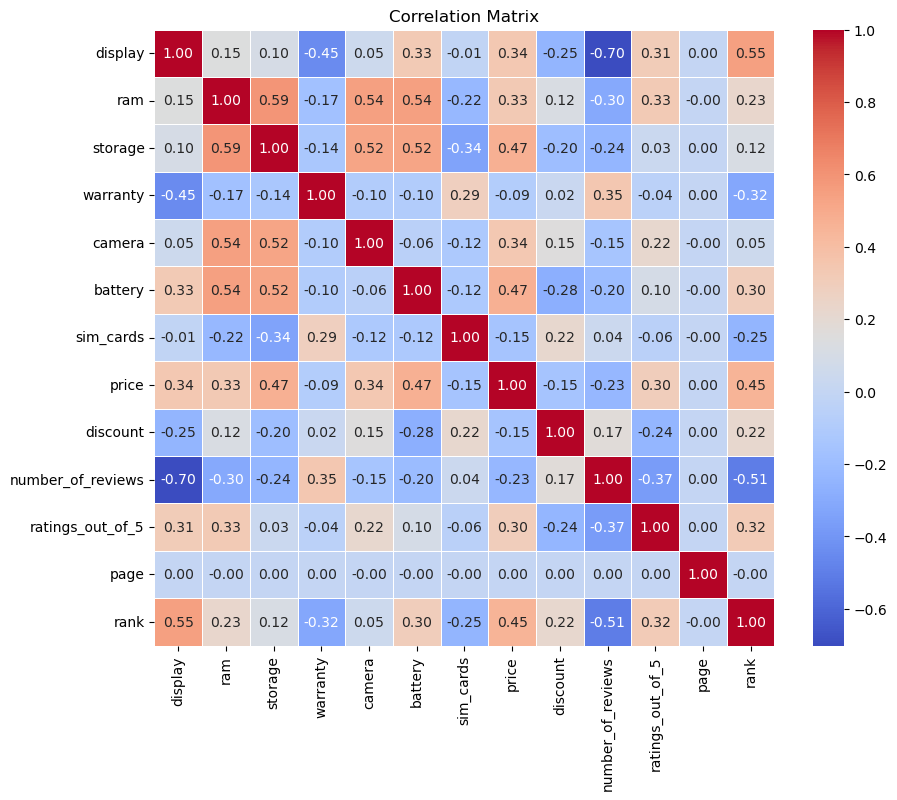

In [89]:
# Let us visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Display the plot
plt.title("Correlation Matrix")
plt.show()